In [1]:
import numpy as np
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "src"))
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from ffnn import FFNN

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report, log_loss, roc_auc_score, cohen_kappa_score, precision_recall_fscore_support

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [3]:
print(X.shape)
print(y.shape) 

(70000, 784)
(70000,)


In [4]:
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

# one-hot encode labels
encoder = OneHotEncoder(sparse=False, categories='auto')
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [57]:
layer_sizes = [784, 150, 75, 10] 
activation_funcs = ["relu", "relu", "softmax"] 
model = FFNN(layer_sizes, activation_funcs=activation_funcs, weight_init="he", loss_function="cce", seed=42)

# model training
history = model.train(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    batch_size=64,
    learning_rate=0.001,
    epochs=50,
    verbose=1
)

Epoch 1/50 - loss: 1.5949 - val_loss: 0.5533
Epoch 2/50 - loss: 0.4467 - val_loss: 0.4129
Epoch 3/50 - loss: 0.3393 - val_loss: 0.3631
Epoch 4/50 - loss: 0.2848 - val_loss: 0.3322
Epoch 5/50 - loss: 0.2507 - val_loss: 0.3156
Epoch 6/50 - loss: 0.2248 - val_loss: 0.2993
Epoch 7/50 - loss: 0.2056 - val_loss: 0.2926
Epoch 8/50 - loss: 0.1906 - val_loss: 0.2846
Epoch 9/50 - loss: 0.1773 - val_loss: 0.2735
Epoch 10/50 - loss: 0.1664 - val_loss: 0.2696
Epoch 11/50 - loss: 0.1576 - val_loss: 0.2639
Epoch 12/50 - loss: 0.1499 - val_loss: 0.2600
Epoch 13/50 - loss: 0.1432 - val_loss: 0.2538
Epoch 14/50 - loss: 0.1361 - val_loss: 0.2573
Epoch 15/50 - loss: 0.1309 - val_loss: 0.2511
Epoch 16/50 - loss: 0.1257 - val_loss: 0.2470
Epoch 17/50 - loss: 0.1202 - val_loss: 0.2538
Epoch 18/50 - loss: 0.1163 - val_loss: 0.2546
Epoch 19/50 - loss: 0.1123 - val_loss: 0.2421
Epoch 20/50 - loss: 0.1079 - val_loss: 0.2458
Epoch 21/50 - loss: 0.1047 - val_loss: 0.2432
Epoch 22/50 - loss: 0.1010 - val_loss: 0.24

In [ ]:
#model.visualize_model()
model.visualize_weight_distribution()
model.visualize_gradient_weight_distribution()
model.visualize_loss_curve()

In [58]:
predictions = model.predict(X_val)

# convert one-hot predictions back to labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_val, axis=1)

In [54]:
def validate_model(model, y_val_encoded, y_val_pred, y_val_pred_proba, label_encoder):
  # Precision, Recall, F1-Score (Weighted and Macro)
  precision, recall, f1, _ = precision_recall_fscore_support(
      y_val_encoded, y_val_pred, average='weighted')
  macro_f1 = f1_score(y_val_encoded, y_val_pred, average='macro')
  print(f"Weighted F1-Score: {f1:.4f}")
  print(f"Macro F1-Score: {macro_f1:.4f}")

  # Cohen's Kappa
  kappa = cohen_kappa_score(y_val_encoded, y_val_pred)
  print(f"Cohen's Kappa: {kappa:.4f}")

  # ROC-AUC (One-vs-Rest for Multi-Class)
  try:
      roc_auc = roc_auc_score(y_val_encoded, y_val_pred_proba, multi_class='ovr', average='weighted')
      print(f"ROC-AUC (Weighted): {roc_auc:.4f}")
  except ValueError:
      print("ROC-AUC could not be computed for this dataset.")

  # Log Loss
  logloss = log_loss(y_val_encoded, y_val_pred_proba)
  print(f"\nValidation Log Loss: {logloss:.4f}")


  # Classfication Report
  print("\nClassification Report:")
  print(classification_report(label_encoder.inverse_transform(y_val_encoded),
                              label_encoder.inverse_transform(y_val_pred),
                              target_names=[str(cls) for cls in label_encoder.classes_] ))

  # Confusion Matrix
  print()
  conf_matrix_id3 = confusion_matrix(label_encoder.inverse_transform(y_val_encoded),
                                    label_encoder.inverse_transform(y_val_pred),
                                    labels=label_encoder.classes_)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_id3, annot=True, fmt='d', cmap='Blues',
              xticklabels=[str(cls) for cls in label_encoder.classes_], 
              yticklabels=[str(cls) for cls in label_encoder.classes_])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

In [59]:
label_encoder = LabelEncoder()
label_encoder.fit(np.arange(10))

y_val_encoded = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(predictions, axis=1) 
y_val_pred_proba = predictions

Weighted F1-Score: 0.9501
Macro F1-Score: 0.9496
Cohen's Kappa: 0.9445
ROC-AUC (Weighted): 0.9968

Validation Log Loss: 0.2667

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1402
           1       0.98      0.98      0.98      1556
           2       0.93      0.96      0.94      1368
           3       0.93      0.92      0.93      1339
           4       0.93      0.95      0.94      1395
           5       0.94      0.95      0.95      1261
           6       0.98      0.95      0.97      1418
           7       0.95      0.95      0.95      1463
           8       0.94      0.95      0.95      1362
           9       0.94      0.91      0.93      1436

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000




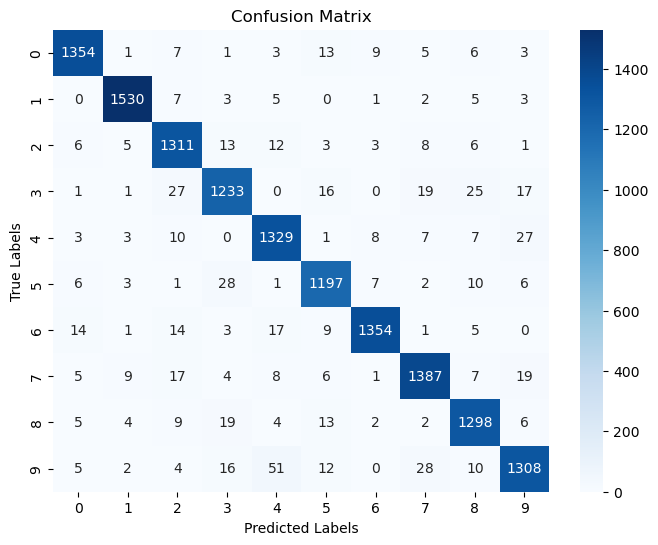

In [60]:
validate_model(model, y_val_encoded, y_val_pred, y_val_pred_proba, label_encoder)
